## Importing the required libraries

In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import keras
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
import os
from keras import regularizers

## link to dataset:
#https://tuenl.sharepoint.com/:f:/r/sites/gad_cbo/JPC/MC/ESA%20PDEng%20ST%20Project/ModelsAndData/Audio/Datasets/Development/tone_cnn_happy_angry_dataset?csf=1&web=1&e=8Tdysz

In [2]:
path = 'C:\\Users\\20195003\\Desktop\\sampless\\'
mylist= os.listdir(path)

## Plotting the audio file's waveform and its spectrogram

In [3]:
data, sampling_rate = librosa.load(path+'03-02-03-01-01-02-01.wav')

Populating the interactive namespace from numpy and matplotlib


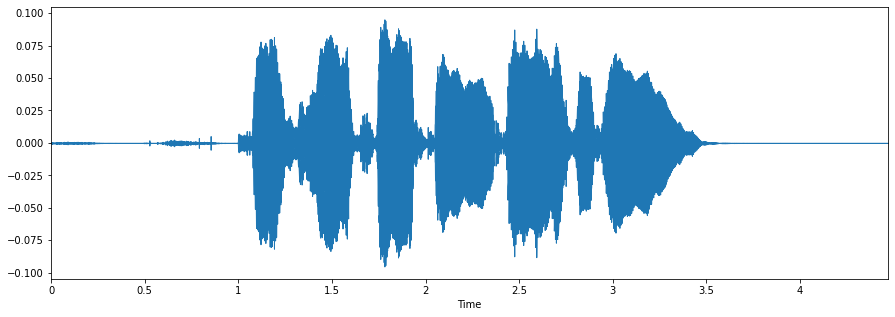

In [4]:
%pylab inline
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

d:\inhouseprojects\esa\model_training\aser_env\lib\site-packages\ipykernel_launcher.py:7: WavFileWarning: Chunk (non-data) not understood, skipping it.
  import sys
d:\inhouseprojects\esa\model_training\aser_env\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log


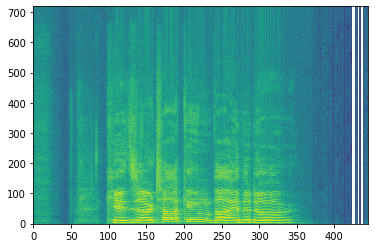

In [5]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys


sr,x = scipy.io.wavfile.read(path+'03-02-03-01-01-02-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

## Setting the labels

In [6]:
feeling_list=[]
for item in mylist:
    if item[6:-16]=='03':
        feeling_list.append('Happy')
    elif item[6:-16]=='05':
        feeling_list.append('Angry')

In [7]:
labels = pd.DataFrame(feeling_list)

In [8]:
labels[:10]

,0
0,Happy
1,Happy
2,Happy
3,Happy
4,Happy
5,Happy
6,Happy
7,Happy
8,Happy
9,Happy


## Getting the features of audio files using librosa

In [9]:
df = pd.DataFrame(columns=['feature'])
bookmark=0
for index,y in enumerate(mylist):
    if mylist[index][6:-16]!='01' and mylist[index][6:-16]!='07' and mylist[index][6:-16]!='08' and mylist[index][:2]!='su' and mylist[index][:1]!='n' and mylist[index][:1]!='d':
        X, sample_rate = librosa.load(path+y, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                            sr=sample_rate, 
                                            n_mfcc=13),
                        axis=0)
        feature = mfccs
        #[float(i) for i in feature]
        #feature1=feature[:135]
        df.loc[bookmark] = [feature]
        bookmark=bookmark+1        

In [10]:
df[:5]

,feature
0,"[-57.81157, -57.81157, -57.81157, -57.81157, -..."
1,"[-61.48604, -57.66557, -57.12638, -56.582607, ..."
2,"[-51.18099, -48.527493, -48.345432, -49.093544..."
3,"[-57.01109, -56.533325, -55.997982, -56.78841,..."
4,"[-59.328495, -58.883247, -59.759052, -59.92489..."


In [11]:
df3 = pd.DataFrame(df['feature'].values.tolist())

df3[:5]

In [12]:
newdf = pd.concat([df3,labels], axis=1)

In [13]:
rnewdf = newdf.rename(index=str, columns={"0": "label"})

In [14]:
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-57.811569,-57.811569,-57.811569,-57.811569,-57.811569,-57.811569,-57.811569,-57.811569,-57.811569,-57.811569,...,-27.088243,-26.903568,-25.609509,-23.793528,-24.944103,-29.169176,-30.318075,-26.655012,-24.080944,Happy
1,-61.486038,-57.665569,-57.126381,-56.582607,-55.035278,-55.799046,-57.433926,-62.278927,-65.778458,-63.584709,...,-34.851105,-34.677933,-36.123165,-36.989803,-39.111004,-39.743771,-40.798538,-31.374004,-25.096994,Happy
2,-51.180988,-48.527493,-48.345432,-49.093544,-49.914085,-45.340370,-43.179131,-44.939434,-46.050205,-45.709995,...,-25.559731,-25.068838,-26.263102,-26.648542,-26.092445,-26.176241,-26.842093,-24.026094,-21.450541,Happy
3,-57.011089,-56.533325,-55.997982,-56.788410,-59.220562,-49.699871,-44.694660,-45.418980,-46.613422,-45.225151,...,-31.554165,-32.205288,-30.608004,-27.605848,-27.247927,-26.957741,-28.461666,-19.024015,-13.877649,Happy
4,-59.328495,-58.883247,-59.759052,-59.924889,-59.335854,-61.184586,-62.073147,-60.721626,-60.067459,-61.735760,...,-31.407734,-32.434601,-32.267960,-31.242699,-31.690929,-31.983614,-32.451920,-26.999935,-23.494106,Happy


In [15]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
12,-47.351765,-47.351765,-47.351765,-47.351765,-47.351765,-47.351765,-47.351765,-47.393234,-47.331501,-47.213520,...,-34.778091,-34.759289,-35.435650,-34.468674,-33.842056,-33.283600,-33.502396,-17.016195,-9.720584,Happy
25,-49.804600,-49.924690,-49.605934,-48.892502,-48.377502,-48.258430,-48.340275,-47.694817,-47.588558,-48.867863,...,-20.209566,-21.177807,-20.831371,-19.722239,-19.957888,-20.166765,-21.966082,-19.247379,-15.707439,Angry
15,-47.009068,-47.387703,-47.875713,-49.496597,-48.368076,-47.545490,-47.604385,-47.896545,-47.376652,-48.484165,...,-28.412235,-28.703968,-28.638834,-30.290831,-29.805490,-28.255247,-26.729494,-20.331326,-15.849621,Happy
29,-49.922585,-47.564087,-47.027061,-46.733109,-47.265465,-48.946121,-50.338737,-49.479622,-49.222858,-50.311119,...,-22.311226,-21.935221,-19.462082,-16.956524,-16.775352,-20.145081,-24.586962,-25.872427,-24.266768,Angry
18,-53.215141,-53.821835,-55.702251,-56.110741,-54.484108,-54.016575,-53.258480,-52.127930,-52.911907,-52.331638,...,-25.371704,-23.986441,-23.056210,-22.540562,-22.526701,-23.259460,-25.210693,-22.763496,-19.199446,Angry
24,-44.510063,-44.510063,-44.510063,-44.510063,-44.510063,-44.510063,-44.510063,-44.510063,-44.510063,-44.510063,...,-37.799252,-38.515030,-36.769436,-35.965473,-35.868401,-34.505363,-35.027534,-33.120918,-27.197109,Angry
8,-53.716934,-53.972878,-53.181664,-53.558559,-54.397457,-51.155869,-47.766846,-48.338928,-49.246017,-48.674454,...,-36.598652,-35.003216,-37.495651,-39.526485,-39.820679,-41.155258,-42.694405,-28.852785,-21.370258,Happy
22,-56.926689,-56.926689,-55.642876,-55.037601,-56.031307,-54.184139,-54.389446,-54.569683,-53.724556,-51.767899,...,-28.287058,-27.620268,-25.867462,-26.129446,-27.805559,-28.043222,-27.774178,-25.139814,-23.523001,Angry
7,-54.618992,-54.074741,-56.352791,-59.550545,-58.432732,-55.242760,-54.547325,-56.185379,-57.388470,-57.412113,...,-31.968554,-30.679962,-31.553383,-27.987570,-25.827244,-24.439589,-25.158400,-21.805180,-16.859730,Happy
31,-42.252037,-42.333694,-44.807594,-46.217442,-43.448059,-42.951027,-41.224636,-40.165993,-40.393204,-40.705563,...,-20.582745,-20.620125,-18.665709,-19.291042,-22.125511,-21.364594,-20.553825,-18.150845,-14.239759,Angry


In [16]:
rnewdf=rnewdf.fillna(0)

## Dividing the data into test and train

In [17]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [18]:
train[10:20]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
33,-45.655830,-45.655830,-45.655830,-45.655830,-45.655830,-45.655830,-45.655830,-45.655830,-45.655830,-45.655830,...,-16.183298,-13.093473,-12.076941,-10.745272,-10.060973,-11.283586,-14.897976,-9.194202,-3.097674,Angry
27,-37.625118,-36.502182,-36.284157,-35.003258,-35.008083,-33.986683,-34.470554,-35.709846,-36.329796,-36.851006,...,-23.599937,-24.584730,-25.418161,-28.237316,-20.587276,-14.192995,-13.168045,-13.368123,-9.639315,Angry
28,-47.702896,-47.702896,-47.702896,-47.702896,-47.702896,-47.702896,-47.702896,-47.702896,-47.702896,-47.702896,...,-27.362644,-28.043377,-23.134401,-21.092741,-22.445751,-23.936392,-24.076235,-23.076202,-23.175047,Angry
0,-57.811569,-57.811569,-57.811569,-57.811569,-57.811569,-57.811569,-57.811569,-57.811569,-57.811569,-57.811569,...,-27.088243,-26.903568,-25.609509,-23.793528,-24.944103,-29.169176,-30.318075,-26.655012,-24.080944,Happy
11,-58.788223,-58.788223,-58.788223,-58.788223,-58.788223,-58.788223,-58.795784,-58.850300,-58.625267,-58.403263,...,-44.192398,-42.330284,-42.752151,-40.835590,-41.134407,-42.385857,-44.025253,-27.757853,-18.597301,Happy
13,-49.968540,-49.968540,-49.968540,-49.968540,-49.968540,-49.968540,-49.968540,-49.968540,-49.968540,-49.968540,...,-39.782124,-39.495949,-41.418335,-40.630791,-40.446209,-40.224079,-38.478226,-38.144226,-36.184620,Happy
34,-45.104153,-44.335060,-42.746910,-40.955994,-43.862366,-45.809456,-46.054970,-44.445454,-44.538925,-43.624466,...,-21.971310,-20.653561,-21.421867,-22.974333,-25.594051,-26.219898,-18.018578,-13.977612,-9.930014,Angry
6,-58.917690,-58.917690,-58.917690,-58.917690,-58.917690,-58.917690,-58.917690,-58.917690,-58.917690,-58.917690,...,-30.747688,-31.649845,-31.559135,-33.048920,-32.931534,-33.156113,-32.168266,-21.888123,-17.059032,Happy
10,-54.338871,-54.439114,-53.253494,-51.503746,-50.149456,-50.131252,-51.179131,-51.233707,-51.549442,-51.617615,...,-40.204258,-41.191975,-41.107647,-40.002007,-40.949379,-43.702965,-42.219986,-27.098656,-19.354637,Happy
23,-46.593891,-46.593891,-46.593891,-46.593891,-46.593891,-46.593891,-46.593891,-46.593891,-46.593891,-46.593891,...,-19.501860,-20.418566,-20.967045,-18.240505,-20.375549,-26.718300,-27.663149,-18.473206,-10.913122,Angry


In [19]:
trainfeatures = train.iloc[:, :-1]

In [20]:
trainlabel = train.iloc[:, -1:]

In [21]:
testfeatures = test.iloc[:, :-1]

In [22]:
testlabel = test.iloc[:, -1:]

In [23]:
from keras.utils import np_utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))


d:\inhouseprojects\esa\model_training\aser_env\lib\site-packages\sklearn\utils\validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


In [24]:
y_train

array([[0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [25]:
X_train.shape

(29, 216)

## Changing dimension for CNN model

In [26]:

x_traincnn =np.expand_dims(X_train, axis=2)
x_testcnn= np.expand_dims(X_test, axis=2)

In [27]:
model = Sequential()

model.add(Conv1D(256, 5,padding='same',
                 input_shape=(216,1)))
model.add(Activation('relu'))
model.add(Conv1D(128, 5,padding='same'))
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Conv1D(128, 5,padding='same',))
#model.add(Activation('relu'))
#model.add(Dropout(0.2))
model.add(Conv1D(128, 5,padding='same',))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.Adam(learning_rate=0.0001)

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 216, 256)          1536      
_________________________________________________________________
activation (Activation)      (None, 216, 256)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 216, 128)          163968    
_________________________________________________________________
activation_1 (Activation)    (None, 216, 128)          0         
_________________________________________________________________
dropout (Dropout)            (None, 216, 128)          0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 27, 128)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 27, 128)           8

In [29]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

### Removed the whole training part for avoiding unnecessary long epochs list

In [30]:
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=200, validation_data=(x_testcnn, y_test))

Epoch 1/200
2/2 [==============================] - 0s 138ms/step - loss: 1.2500 - accuracy: 0.5172 - val_loss: 0.7277 - val_accuracy: 0.5000
Epoch 2/200
2/2 [==============================] - 0s 40ms/step - loss: 0.7154 - accuracy: 0.4828 - val_loss: 0.8154 - val_accuracy: 0.5000
Epoch 3/200
2/2 [==============================] - 0s 38ms/step - loss: 0.7732 - accuracy: 0.4828 - val_loss: 0.7172 - val_accuracy: 0.5000
Epoch 4/200
2/2 [==============================] - 0s 37ms/step - loss: 0.6593 - accuracy: 0.6897 - val_loss: 0.6819 - val_accuracy: 0.5000
Epoch 5/200
2/2 [==============================] - 0s 33ms/step - loss: 0.6862 - accuracy: 0.5517 - val_loss: 0.6996 - val_accuracy: 0.5000
Epoch 6/200
2/2 [==============================] - 0s 33ms/step - loss: 0.6550 - accuracy: 0.5172 - val_loss: 0.6836 - val_accuracy: 0.5000
Epoch 7/200
2/2 [==============================] - 0s 31ms/step - loss: 0.6148 - accuracy: 0.6897 - val_loss: 0.7005 - val_accuracy: 0.5000
Epoch 8/200
2/2 [==

2/2 [==============================] - 0s 30ms/step - loss: 0.2654 - accuracy: 0.9655 - val_loss: 0.5036 - val_accuracy: 0.8333
Epoch 60/200
2/2 [==============================] - 0s 32ms/step - loss: 0.2630 - accuracy: 0.9655 - val_loss: 0.4974 - val_accuracy: 0.8333
Epoch 61/200
2/2 [==============================] - 0s 31ms/step - loss: 0.2618 - accuracy: 0.9310 - val_loss: 0.4877 - val_accuracy: 0.8333
Epoch 62/200
2/2 [==============================] - 0s 30ms/step - loss: 0.2524 - accuracy: 0.9655 - val_loss: 0.4666 - val_accuracy: 1.0000
Epoch 63/200
2/2 [==============================] - 0s 32ms/step - loss: 0.2459 - accuracy: 0.9655 - val_loss: 0.4622 - val_accuracy: 1.0000
Epoch 64/200
2/2 [==============================] - 0s 39ms/step - loss: 0.2493 - accuracy: 0.9310 - val_loss: 0.4711 - val_accuracy: 0.8333
Epoch 65/200
2/2 [==============================] - 0s 40ms/step - loss: 0.2442 - accuracy: 0.8966 - val_loss: 0.4626 - val_accuracy: 0.8333
Epoch 66/200
2/2 [========

2/2 [==============================] - 0s 36ms/step - loss: 0.0758 - accuracy: 1.0000 - val_loss: 0.2411 - val_accuracy: 0.8333
Epoch 118/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0569 - accuracy: 1.0000 - val_loss: 0.1905 - val_accuracy: 1.0000
Epoch 119/200
2/2 [==============================] - 0s 34ms/step - loss: 0.0732 - accuracy: 1.0000 - val_loss: 0.1802 - val_accuracy: 1.0000
Epoch 120/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0569 - accuracy: 1.0000 - val_loss: 0.2726 - val_accuracy: 0.8333
Epoch 121/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0657 - accuracy: 1.0000 - val_loss: 0.2470 - val_accuracy: 0.8333
Epoch 122/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0526 - accuracy: 1.0000 - val_loss: 0.1737 - val_accuracy: 1.0000
Epoch 123/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0619 - accuracy: 1.0000 - val_loss: 0.1717 - val_accuracy: 1.0000
Epoch 124/200
2/2 [=

Epoch 175/200
2/2 [==============================] - 0s 34ms/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 0.0846 - val_accuracy: 1.0000
Epoch 176/200
2/2 [==============================] - 0s 33ms/step - loss: 0.0113 - accuracy: 1.0000 - val_loss: 0.0813 - val_accuracy: 1.0000
Epoch 177/200
2/2 [==============================] - 0s 32ms/step - loss: 0.0110 - accuracy: 1.0000 - val_loss: 0.0897 - val_accuracy: 1.0000
Epoch 178/200
2/2 [==============================] - 0s 35ms/step - loss: 0.0101 - accuracy: 1.0000 - val_loss: 0.0975 - val_accuracy: 1.0000
Epoch 179/200
2/2 [==============================] - 0s 31ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.0839 - val_accuracy: 1.0000
Epoch 180/200
2/2 [==============================] - 0s 30ms/step - loss: 0.0100 - accuracy: 1.0000 - val_loss: 0.0734 - val_accuracy: 1.0000
Epoch 181/200
2/2 [==============================] - 0s 40ms/step - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.0779 - val_accuracy: 1.0000
Epoch 

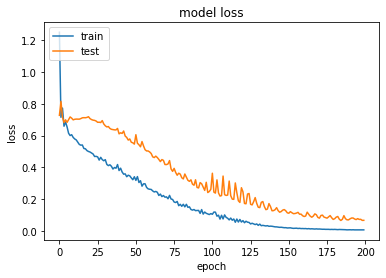

In [31]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Saving the model

In [32]:
model_name = 'Emotion_Voice_Detection_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')
# Save model and weights
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)

Saved trained model at D:\InhouseProjects\ESA\model_training\tone\prototype\saved_models\Emotion_Voice_Detection_Model.h5 


In [33]:
import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

## Loading the model

In [34]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Voice_Detection_Model.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 100.00%


## Predicting emotions on the test data

In [35]:
preds = loaded_model.predict(x_testcnn, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 1ms/step


In [36]:
preds

array([[0.98747665, 0.01252343],
       [0.01922515, 0.9807748 ],
       [0.07310092, 0.9268991 ],
       [0.01604338, 0.98395663],
       [0.9816589 , 0.01834113],
       [0.768561  , 0.231439  ]], dtype=float32)

In [37]:
preds1=preds.argmax(axis=1)

In [38]:
preds1

array([0, 1, 1, 1, 0, 0], dtype=int64)

In [39]:
abc = preds1.astype(int).flatten()

In [40]:
predictions = (lb.inverse_transform((abc)))

In [41]:
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf

,predictedvalues
0,Angry
1,Happy
2,Happy
3,Happy
4,Angry
5,Angry


In [42]:
actual=y_test.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))

In [43]:
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf

,actualvalues
0,Angry
1,Happy
2,Happy
3,Happy
4,Angry
5,Angry


In [44]:
finaldf = actualdf.join(preddf)

## Actual v/s Predicted emotions

In [45]:
finaldf[0:4]

,actualvalues,predictedvalues
0,Angry,Angry
1,Happy,Happy
2,Happy,Happy
3,Happy,Happy


In [46]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
Angry,3
Happy,3


In [47]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
Angry,3
Happy,3


In [48]:
finaldf.to_csv('Predictions.csv', index=False)

## Live Demo

#### The file 'output10.wav' in the next cell is the file that was recorded live using the code in AudioRecoreder notebook found in the repository

In [53]:
data, sampling_rate = librosa.load('output10.wav')

Populating the interactive namespace from numpy and matplotlib


d:\inhouseprojects\esa\model_training\aser_env\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


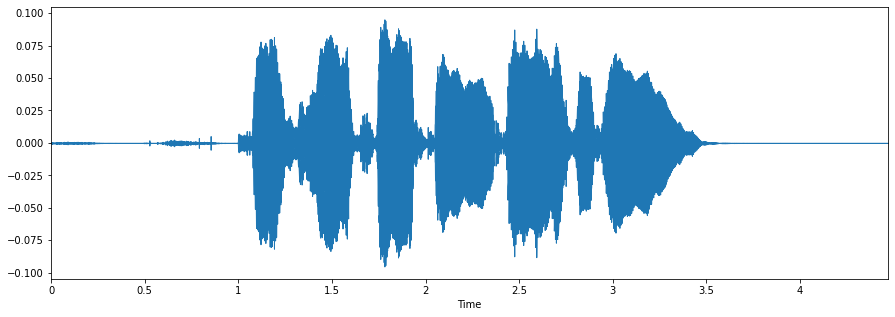

In [50]:
%pylab inline
import os
import pandas as pd
import librosa
import glob 

plt.figure(figsize=(15, 5))
librosa.display.waveplot(data, sr=sampling_rate)

In [51]:
#livedf= pd.DataFrame(columns=['feature'])
X, sample_rate = librosa.load('Recording.wav', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
featurelive = mfccs
livedf2 = featurelive

FileNotFoundError: [Errno 2] No such file or directory: 'Recording.wav'

In [376]:
livedf2= pd.DataFrame(data=livedf2)

In [377]:
livedf2 = livedf2.stack().to_frame().T

In [378]:
livedf2

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0,-42.318398,-42.318398,-42.318398,-42.318398,-42.318398,-42.318398,-42.318398,-42.318398,-42.318398,-42.318398,...,-24.143869,-24.293356,-24.797838,-25.788174,-25.055706,-23.645973,-21.937735,-18.940521,-17.401972,-14.991854


In [379]:
twodim= np.expand_dims(livedf2, axis=2)

In [380]:
livepreds = loaded_model.predict(twodim, 
                         batch_size=32, 
                         verbose=1)

1/1 [==============================] - 0s 2ms/step


In [381]:
livepreds

array([[0.9282272 , 0.07177284]], dtype=float32)

In [382]:
livepreds1=livepreds.argmax(axis=1)

In [383]:
liveabc = livepreds1.astype(int).flatten()

In [384]:
livepredictions = (lb.inverse_transform((liveabc)))
livepredictions

array(['Angry'], dtype=object)